In [1]:
import torch
import os
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from typing import List, Tuple, Dict 
import random
from pathlib import Path
from PIL import Image
from torchinfo import summary
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.io import read_image
import torchvision
from torchvision.transforms import ToTensor
from torchvision import datasets
from torchvision import transforms
#from tqdm.auto import tqdm
#from torchvision.transforms.v2 import SanitizeBoundingBox as SBox


print(f'PyTorch version: {torch.__version__}')
print(f'torchvision version: {torchvision.__version__}')

# https://medium.com/@anumolcs1996/image-gradient-for-edge-detection-in-pytorch-a9498a7827d6

PyTorch version: 2.0.1
torchvision version: 0.15.2


In [2]:
img_class_name = {0:'clean', 1:'dirty'}
img_class_name_inverse = {'clean':0, 'dirty':1}

In [3]:
img_partition = {0:'train', 1:'test', 2:'hidden'}
img_partition_inverse = {'train':0, 'test':1, 'hidden':2}

In [4]:
class CudaHelper:
    
    def get_device():
        device = "cuda" if torch.cuda.is_available() else "cpu"
        #device = 'cpu'
        return device

In [5]:
class ImageItem:
    
    def __init__(self, image:torch.Tensor, full_path:str, image_class:int, image_partition:int):
        self.image = image
        self.full_path = full_path
        self.image_class = image_class
        self.image_partition = image_partition
    
    def stringify(self):
        return f'Class: {img_class_name[self.image_class]}:{self.image_class}. Partition: {img_partition[self.image_partition]}'

In [6]:
class ImageHelper:
    
    def plot_tensor(img:torch.Tensor):
        img_cpu = img.squeeze().to('cpu')
        plt.imshow(img_cpu.permute(1, 2, 0))
        plt.show()
    
    def plot_img(img:ImageItem):
        img_cpu = img.image.squeeze().to('cpu')
        plt.imshow(img_cpu.permute(1, 2, 0))
        plt.title(f'{img.stringify()}')
        plt.show()
    
    def do_load(data_dir:str, partition:str, class_name:str) -> List[ImageItem]:
        all_files = os.listdir(data_dir)
        all_images = []

        for f in all_files:
            full_path = os.path.join(data_dir, f)
            img_tensor = read_image(full_path).to(CudaHelper.get_device())
            ii = ImageItem(img_tensor, full_path, img_class_name_inverse[class_name], img_partition_inverse[partition])
            all_images.append(ii)
        
        return all_images
    
    def load_images(base_dir:str, partition:str) -> List[ImageItem]:        
        cleans = ImageHelper.do_load(os.path.join(base_dir, partition, 'clean'), partition, 'clean')
        dirtys = ImageHelper.do_load(os.path.join(base_dir, partition, 'dirty'), partition, 'dirty')
        return cleans, dirtys
    
    def gradient_transform(img:torch.Tensor):
        img = img.squeeze(0)
        ten=torch.unbind(img)
        x=ten[0].unsqueeze(0).unsqueeze(0)

        a=np.array([[1, 0, -1],[2,0,-2],[1,0,-1]])
        conv1=nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1, bias=False)
        conv1.weight=nn.Parameter(torch.from_numpy(a).float().unsqueeze(0).unsqueeze(0))
        G_x=conv1(Variable(x)).data.view(1,x.shape[2],x.shape[3])

        b=np.array([[1, 2, 1],[0,0,0],[-1,-2,-1]])
        conv2=nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1, bias=False)
        conv2.weight=nn.Parameter(torch.from_numpy(b).float().unsqueeze(0).unsqueeze(0))
        G_y=conv2(Variable(x)).data.view(1,x.shape[2],x.shape[3])

        G=torch.sqrt(torch.pow(G_x,2)+ torch.pow(G_y,2))
        return G


In [7]:
class ImageTransformer:
    
    def plot_transformed_images(image_items:List[ImageItem], transform, n=3, seed=42):

        random.seed(seed)
        random_image_items = random.sample(image_items, k=n)
        for item in random_image_items:
            with Image.open(item.full_path) as f:

                # original
                fig, ax = plt.subplots(1, 2)
                ax[0].imshow(f) 
                ax[0].set_title(f"Original \nSize: {f.size}")
                ax[0].axis("off")

                # transformed
                transformed_image = transform(f).permute(1, 2, 0) 
                ax[1].imshow(transformed_image) 
                ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
                ax[1].axis("off")

                fig.suptitle(f"{item.stringify()}", fontsize=16)

In [8]:
class ModelHelper:
    
    def print_model_info(model:nn.Module):
        print(model_0)
    
    def print_model_info_full(model:nn.Module):
        print(summary(model_0, input_size=[1, 3, 64, 64]))

## Print several random images

In [9]:
main_dir = 'C:\\Users\\Valentine\\Downloads\\NeuralNetworks\\plates\\plates\\'

clean_train, dirty_train = ImageHelper.load_images(main_dir, 'train')
clean_test, dirty_test = ImageHelper.load_images(main_dir, 'test')
clean_hidden, dirty_hidden = ImageHelper.load_images(main_dir, 'hidden')

In [10]:
_ALL_ITEMS_ = [*clean_train, *dirty_train, *clean_test, *dirty_test, *clean_hidden, *dirty_hidden]
_ALL_PATHS_ = [i.full_path for i in _ALL_ITEMS_]

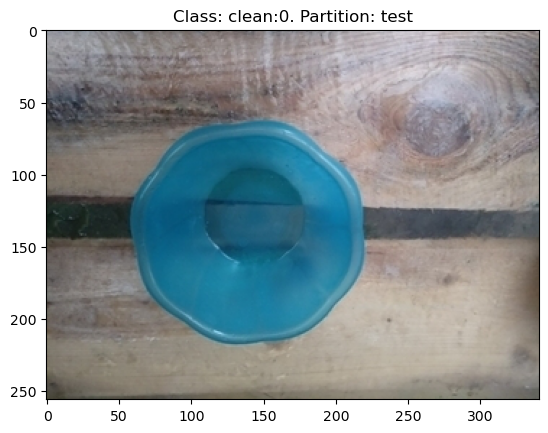

In [11]:
ImageHelper.plot_img(random.choice(_ALL_ITEMS_))

## Do image augmentation 

In [12]:
data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5), 
    transforms.ToTensor()
])

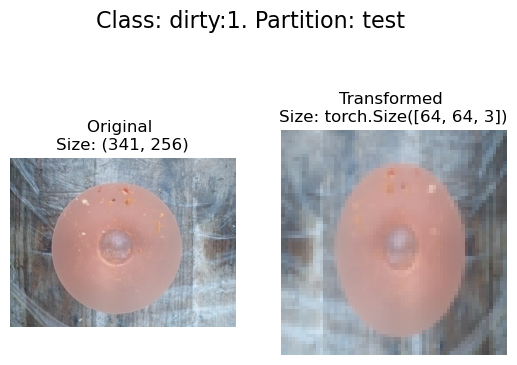

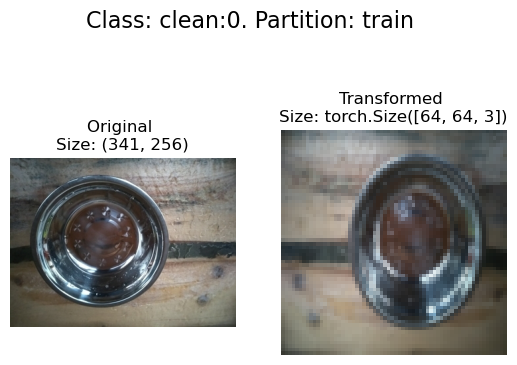

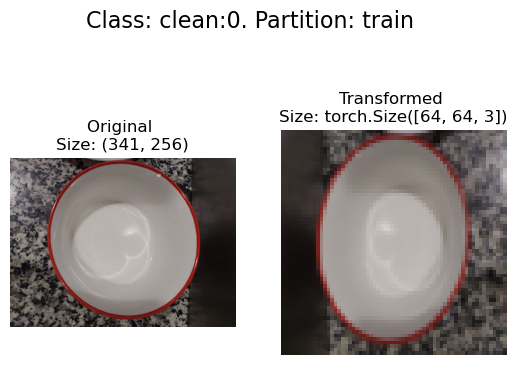

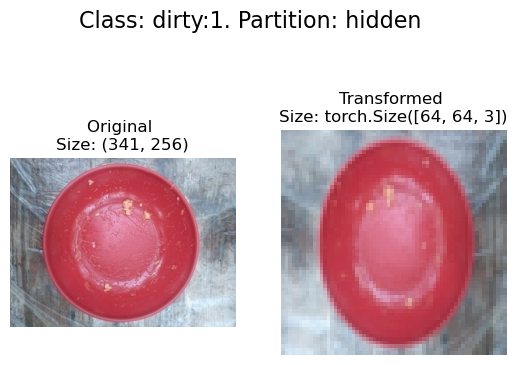

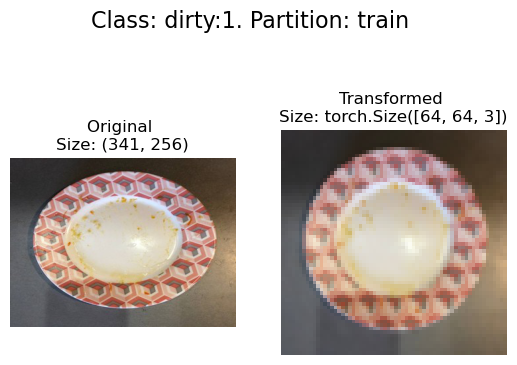

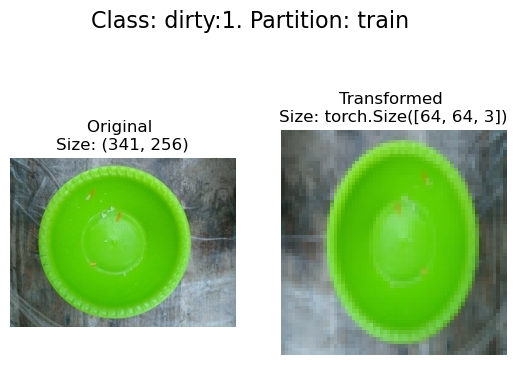

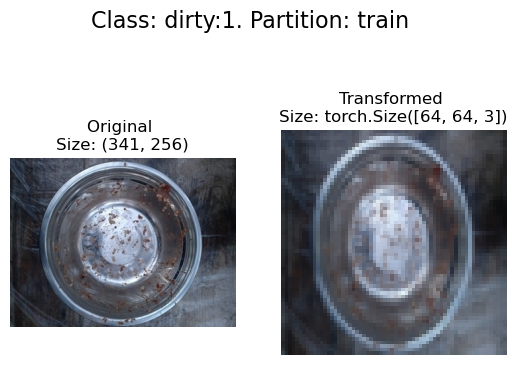

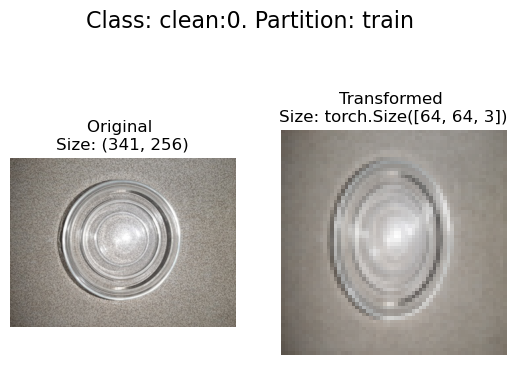

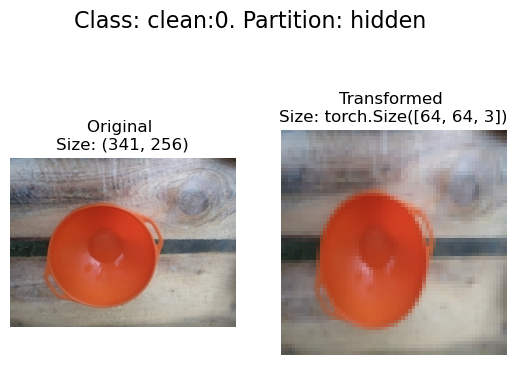

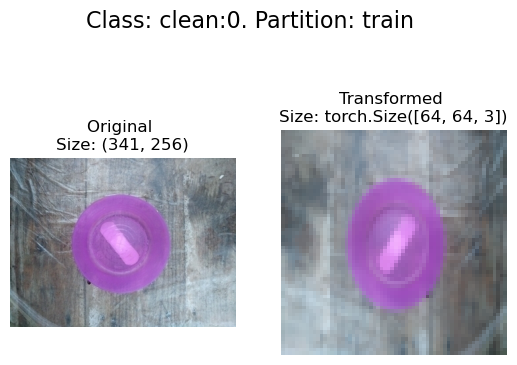

In [13]:
ImageTransformer.plot_transformed_images(_ALL_ITEMS_, transform=data_transform, n=10)

## Create data loader

In [14]:
train_path = Path(clean_train[0].full_path).parent.parent
test_path = Path(clean_test[0].full_path).parent.parent

In [15]:
train_data = datasets.ImageFolder(root=train_path, transform=data_transform)
test_data = datasets.ImageFolder(root=test_path, transform=data_transform) 
train_dataloader = DataLoader(dataset=train_data, batch_size=1, num_workers=1, shuffle=True) 
test_dataloader = DataLoader(dataset=test_data, batch_size=1, num_workers=1, shuffle=False)

## Create model

In [16]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion

In [17]:
model_0 = TinyVGG(input_shape=3, hidden_units=10, output_shape=len(train_data.classes)).to(CudaHelper.get_device())

In [18]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    
    device = CudaHelper.get_device()
    
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [19]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    
    device = CudaHelper.get_device()
    
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [20]:
# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in range(epochs):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

In [21]:
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 50

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=len(train_data.classes)).to(CudaHelper.get_device())

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_0 
model_0_results = train(model=model_0, 
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

Epoch: 1 | train_loss: 0.6973 | train_acc: 0.5100 | test_loss: 0.6753 | test_acc: 0.6667
Epoch: 2 | train_loss: 0.6951 | train_acc: 0.5167 | test_loss: 0.6849 | test_acc: 0.6667
Epoch: 3 | train_loss: 0.6943 | train_acc: 0.4767 | test_loss: 0.6860 | test_acc: 0.6644
Epoch: 4 | train_loss: 0.6944 | train_acc: 0.5267 | test_loss: 0.6136 | test_acc: 0.7867
Epoch: 5 | train_loss: 0.7025 | train_acc: 0.4900 | test_loss: 0.6882 | test_acc: 0.6667
Epoch: 6 | train_loss: 0.6937 | train_acc: 0.5333 | test_loss: 0.6505 | test_acc: 0.7889
Epoch: 7 | train_loss: 0.6870 | train_acc: 0.5867 | test_loss: 0.7117 | test_acc: 0.3600
Epoch: 8 | train_loss: 0.6968 | train_acc: 0.5100 | test_loss: 0.6776 | test_acc: 0.6667
Epoch: 9 | train_loss: 0.6957 | train_acc: 0.4600 | test_loss: 0.6898 | test_acc: 0.6689
Epoch: 10 | train_loss: 0.6936 | train_acc: 0.5033 | test_loss: 0.6911 | test_acc: 0.6511
Total training time: 168.189 seconds


In [22]:
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [23]:
def plot_loss_curves(results: dict[str, list[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

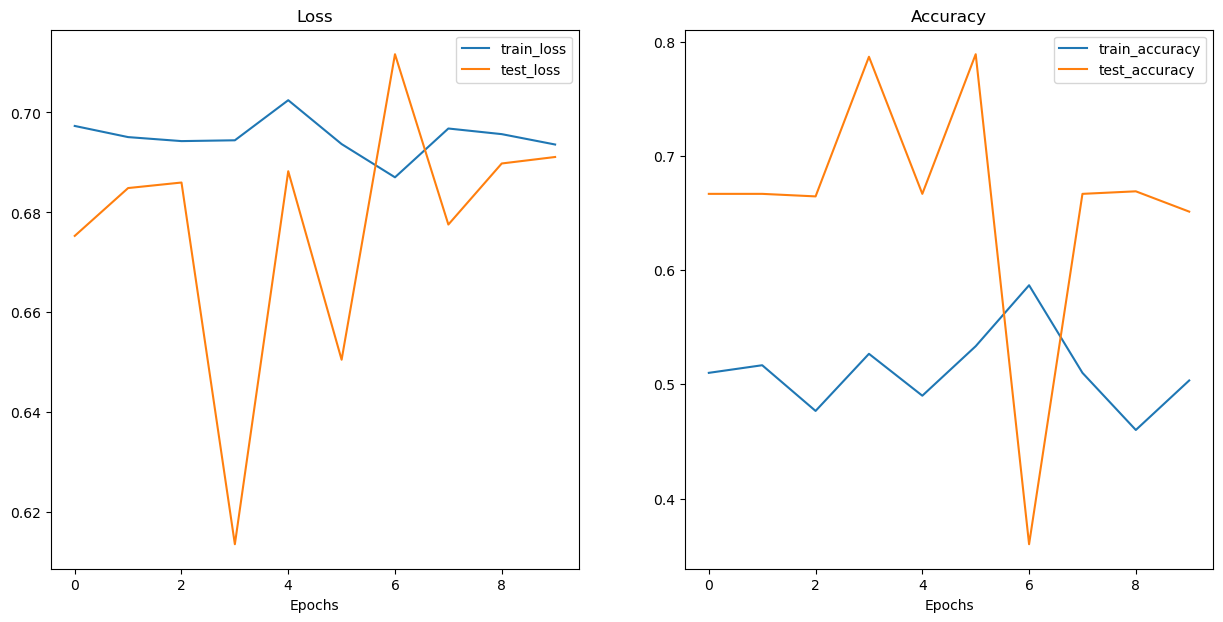

In [24]:
plot_loss_curves(model_0_results)